# E-commerce Exploratory Analytics
### Xuechen Qin
### 2024-11-24

## Background
With the rise of e-commerce, understanding customer behavior and purchasing patterns is vital for online businesses. Utilizing transactional data can provide actionable insights, helping to optimize sales strategies, improve customer experiences, and maximize revenue. This study primaryly aim to assist an online retailer by analyzing their transaction data to uncover sales trends, customer segmentation, and potential areas of improvement.

## Data Cleaning & Preprocessing
The dataset captures transactions from December 2010 to December 2011 from a UK-based online retailer. It contains 541909 rows and 8 columns before cleaning and validation. Fields include:

From the initial inspection, we see several issues that need addressing:

- `InvoiceDate` is an object type and should be converted to datetime.
- `CustomerID` has a significant number of missing values. We drop missing values in this study, since we cannot impute the customerID.
- `Description` also has some missing values. It could be filled with `UNKOWN`.

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [36]:
# Load the dataset
file_path = "Online Retail.csv"
df = pd.read_csv(file_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [37]:
# Print basic information about the dataset
df.info()
# Print missing value statistics
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [38]:
df.dropna(subset=["CustomerID"], inplace=True)
df.fillna({"Description": "Unknown"}, inplace=True)
df["CustomerID"] = df["CustomerID"].astype(int)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%d/%m/%Y %H:%M")

In [39]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [40]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


The negative `Quantity` could be interpreted as the result of cancellation of order and were not handled here.

In [41]:
df.duplicated().sum()

np.int64(5225)

In [42]:
df[df.duplicated(keep=False)].sort_values(["InvoiceNo", "StockCode"]).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom


Duplicate values could be interpreted as the result of multiple simultaneous purchases and are not handled here.

In [43]:
# drop rows with negative or zero quantity or unit price
df_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

# Create a new column for total price
# TotalPrice = Quantity * UnitPrice
df_sales["TotalPrice"] = df_sales["Quantity"] * df_sales["UnitPrice"]

In [44]:
df_sales["YearMonth"] = df_sales["InvoiceDate"].dt.to_period("M")

## In-depth Exploratory Data Analysis

### Q1. What are the most popular products and how do their sales vary over time?

To find the most popular products, I'll rank them by the total quantity sold. Then, for the top products, I will plot their monthly sales quantity to observe the trends over time.

In [45]:
# Q1. Popular Products & Sales Trends
popular_products = (
    df_sales.groupby("Description")["Quantity"].sum().sort_values(ascending=False)
)
top_10_products = popular_products.head(10).index

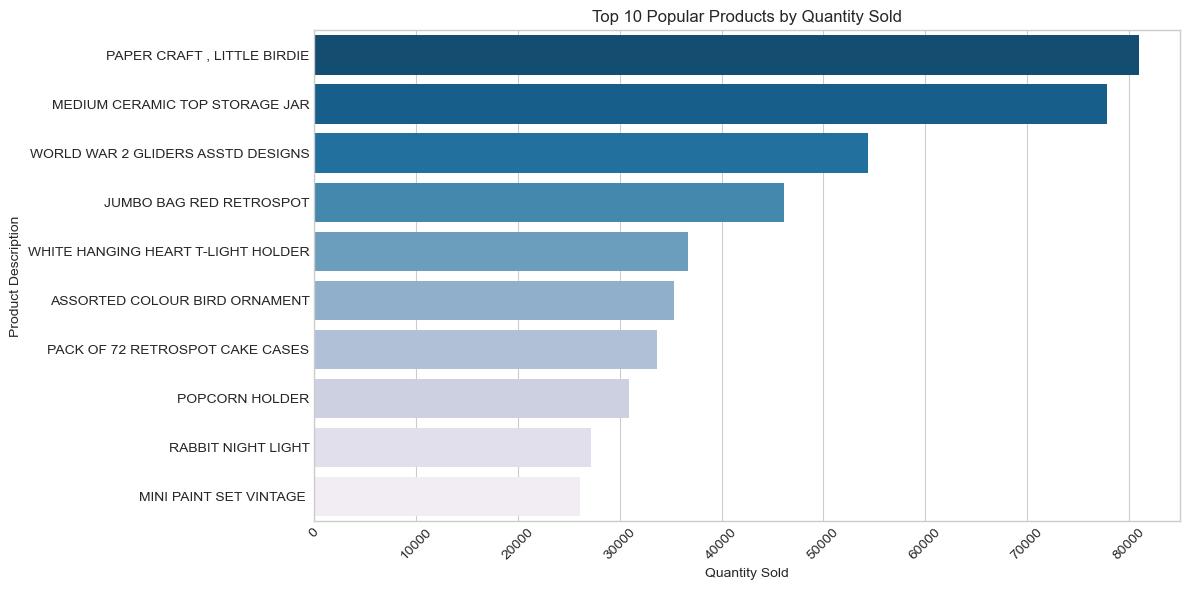

In [46]:
# plot top 10 products sales
plt.figure(figsize=(12, 6))
sns.barplot(
    x=popular_products.head(10).values,
    y=popular_products.head(10).index,
    hue=popular_products.head(10).index,
    palette="PuBu_r",
)
plt.title("Top 10 Popular Products by Quantity Sold")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
# Sales trends over time
monthly_top_product_sales = df_sales[df_sales["Description"].isin(top_10_products)]
monthly_sales_pivot = (
    monthly_top_product_sales.groupby(["YearMonth", "Description"])["Quantity"]
    .sum()
    .unstack(fill_value=0)
)

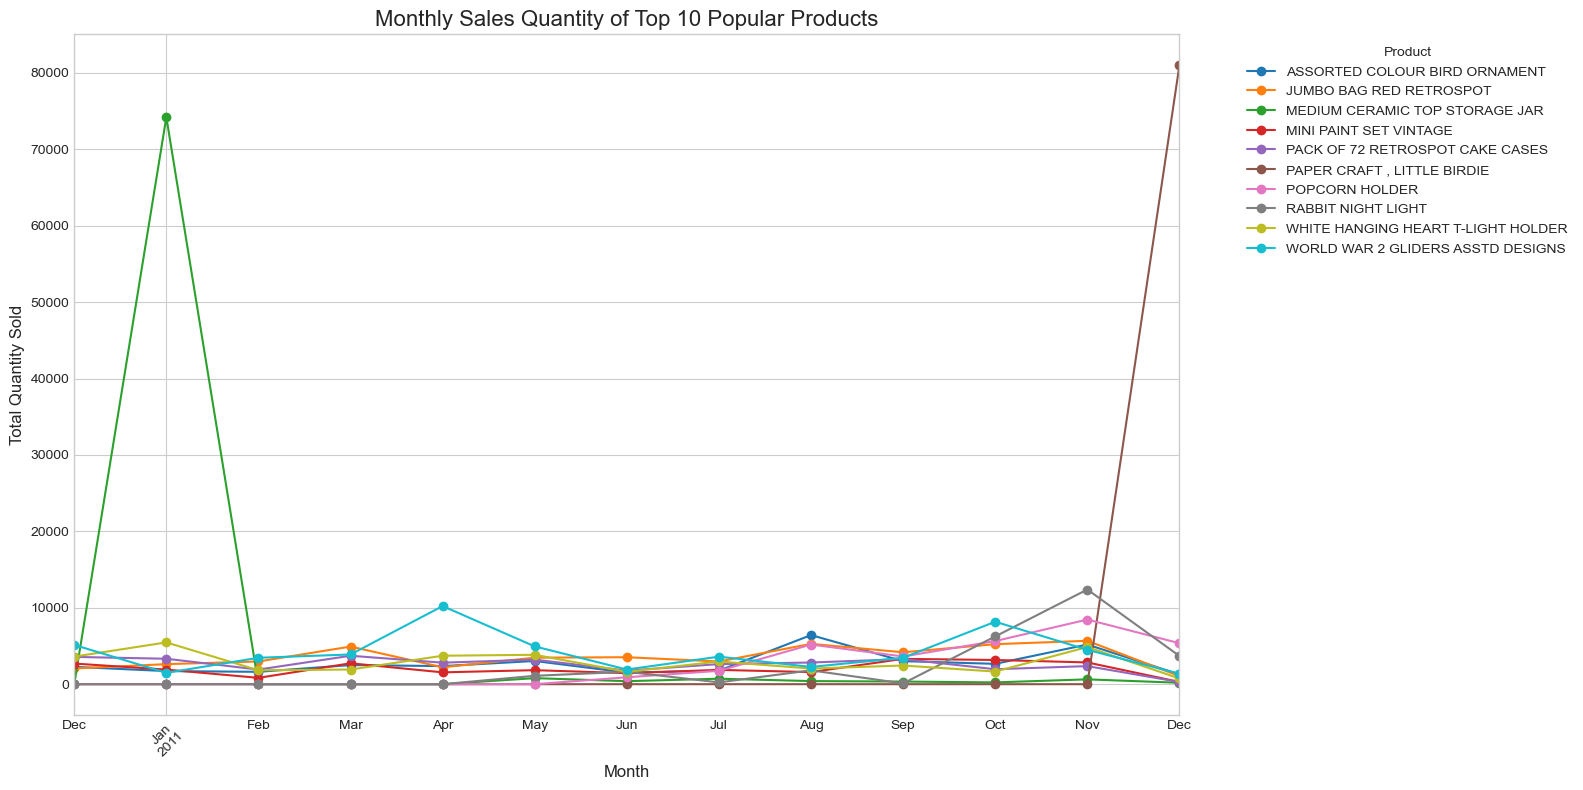

In [48]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 8))
monthly_sales_pivot.plot(kind="line", ax=ax, marker="o")
ax.set_title(
    "Monthly Sales Quantity of Top 10 Popular Products", fontsize=16
)  # title: top 10 popular products monthly sales
ax.set_xlabel("Month", fontsize=12)  # Xlabel: month
ax.set_ylabel("Total Quantity Sold", fontsize=12)  # ylabel: total quantity sold
ax.legend(title="Product", bbox_to_anchor=(1.05, 1), loc="upper left")  # legend
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Findings from Q1:**

- The chart clearly shows the monthly sales quantities for the top 10 most popular items.

- The product `MEDIUM CERAMIC TOP STORAGE JAR` exhibit a significant sales peak in January, which is likely due to holiday season shopping.

- Some products, like `WORLD WAR2 GLIDERS ASSTD DESIGNS`, are consistently popular throughout the year, while others have more seasonal demand.

- The product `RABBIT NIGHT LIGHT` and `PAPER CRAFT, LITTLE BIRDIE` were introduced late in the year and immediately became a bestseller, indicating a highly successful product launch.

### Q2. Can we segment customers based on their purchasing behavior?
A very effective and common technique for this is RFM analysis. RFM stands for:

- Recency: How recently did the customer purchase?

- Frequency: How often do they purchase?

- Monetary: How much do they spend?

I will calculate these three values for each customer and then assign a score from 1 to 4 to each dimension. This allows us to create meaningful customer segments.


In [49]:
# Set a snapshot date for recency calculation.
snapshot_date = df_sales["InvoiceDate"].max() + dt.timedelta(days=1)

# Calculate RFM values for each customer.
rfm_data = df_sales.groupby("CustomerID").agg(
    {
        "InvoiceDate": lambda date: (snapshot_date - date.max()).days,  # Recency
        "InvoiceNo": "nunique",  # Frequency
        "TotalPrice": "sum",  # Monetary
    }
)
rfm_data.rename(
    columns={
        "InvoiceDate": "Recency",
        "InvoiceNo": "Frequency",
        "TotalPrice": "Monetary",
    },
    inplace=True,
)

In [50]:
# RFM Scoring using qcut
rfm_data["R_Score"] = pd.qcut(rfm_data["Recency"], 4, labels=[4, 3, 2, 1]).astype(int)
rfm_data["F_Score"] = pd.qcut(
    rfm_data["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4]
).astype(int)
rfm_data["M_Score"] = pd.qcut(rfm_data["Monetary"], 4, labels=[1, 2, 3, 4]).astype(int)


# Define segments based on RFM scores.
def segment_customer(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4:
        return "Best Customers"
    elif row["R_Score"] >= 3 and row["F_Score"] >= 3:
        return "Loyal Customers"
    elif row["R_Score"] >= 3:
        return "Potential Loyalist"
    elif row["F_Score"] >= 3:
        return "At Risk"
    elif row["R_Score"] < 2 and row["F_Score"] < 2:
        return "Lost"
    else:
        return "Needs Attention"


rfm_data["Segment"] = rfm_data.apply(segment_customer, axis=1)

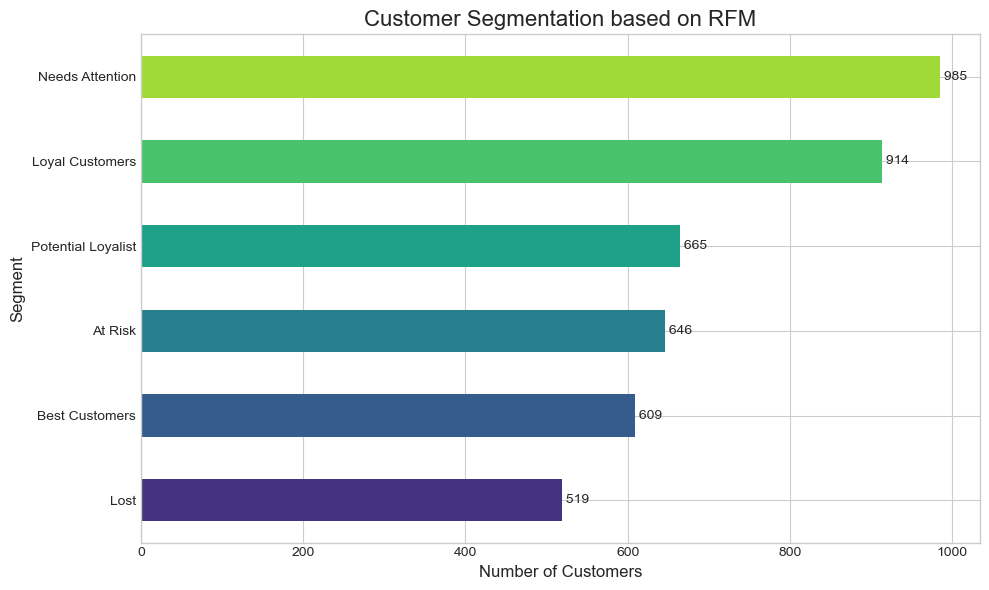

In [51]:
segment_counts = rfm_data["Segment"].value_counts().sort_values(ascending=True)
plt.figure(figsize=(10, 6))
segment_counts.plot(
    kind="barh", color=sns.color_palette("viridis", len(segment_counts))
)
plt.title("Customer Segmentation based on RFM", fontsize=16)
plt.xlabel("Number of Customers", fontsize=12)
plt.ylabel("Segment", fontsize=12)
for index, value in enumerate(segment_counts):
    plt.text(value, index, f" {value}", va="center")
plt.tight_layout()
plt.show()

In [52]:
print("Segment Counts:\n")
print(segment_counts)
print("\nTotal Customers:", rfm_data.shape[0])

Segment Counts:

Segment
Lost                  519
Best Customers        609
At Risk               646
Potential Loyalist    665
Loyal Customers       914
Needs Attention       985
Name: count, dtype: int64

Total Customers: 4338


**Findings:**

The RFM analysis reveals several distinct customer segments:

- **Best Customers (609)**: High-value core group that purchases recently and frequently. Prime candidates for loyalty programs and exclusive offers.

- **Loyal Customers (914)**: Largest segment showing consistent purchasing patterns. Focus on retention strategies and upselling opportunities.

- **At Risk (646)**: Previously frequent buyers who haven't made recent purchases. Require immediate re-engagement through targeted promotions.

- **Lost (519)**: Historically inactive customers with infrequent purchases. Re-acquisition may not be cost-effective.

- **Potential Loyalists (665)**: Recent but infrequent purchasers. With proper nurturing, they could become loyal customers.

- **Needs Attention (985)**: Significant group requiring strategic intervention to prevent migration to the Lost segment.

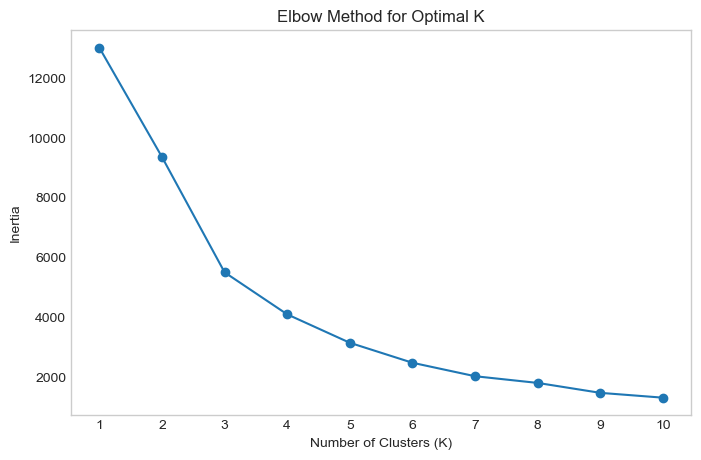

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Prepare data for clustering
X = rfm_data[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(X)


# Determine the optimal number of clusters using the Elbow method plot
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(range(1, 11))
plt.grid()
plt.show()

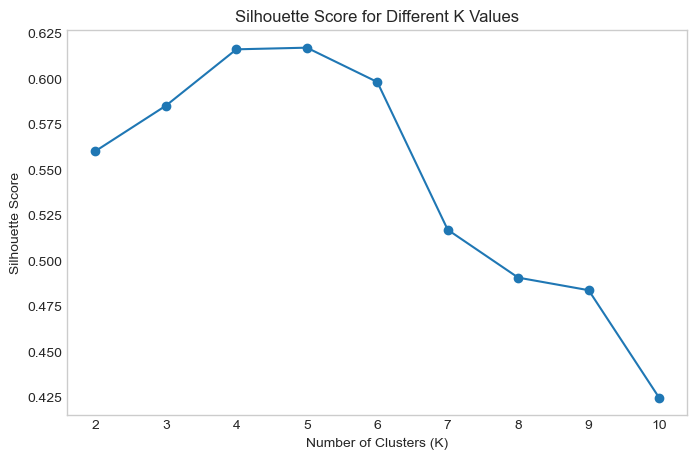

In [54]:
# Check the optimal number of clusters using the silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.title("Silhouette Score for Different K Values")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 11))
plt.grid()
plt.show()

In [55]:
# Based on the Elbow method and silhouette score, we can choose an optimal K value.
# For example, let's assume we found that K=4 is optimal.
optimal_k = 4
kmeans = KMeans(
    n_clusters=optimal_k, init="k-means++", n_init=10, max_iter=300, random_state=42
)
rfm_data["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Analyze the clusters
cluster_summary = (
    rfm_data.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)
)
print("\n--- K-Means Cluster Summary (RFM Averages) ---")
print(cluster_summary)

print("\n--- Cluster Distribution ---")
print(rfm_data["Cluster"].value_counts().sort_index())

print("\nTotal Customers:", rfm_data["Cluster"].value_counts().sum())


--- K-Means Cluster Summary (RFM Averages) ---
         Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1359.05
1         248.08       1.55     480.62
2           7.38      82.54  127338.31
3          15.50      22.33   12709.09

--- Cluster Distribution ---
Cluster
0    3054
1    1067
2      13
3     204
Name: count, dtype: int64

Total Customers: 4338


**Cluster Profiles:**

The summary table shows the "center" of each cluster. They could be interpreted:

- **Cluster 0:** These are  Loyal Customers. They are the stable, consistent core of the business.

- **Cluster 1:** These are Inactive or Lost Customers. They have a low probability of returning on their own.

- **Cluster 2:** This is a small but mighty group of Whale/VIP Customers. They are likely businesses (resellers) rather than individuals.

- **Cluster 3:** These are Important Customers. They are recent, frequent, and high-spending individuals.

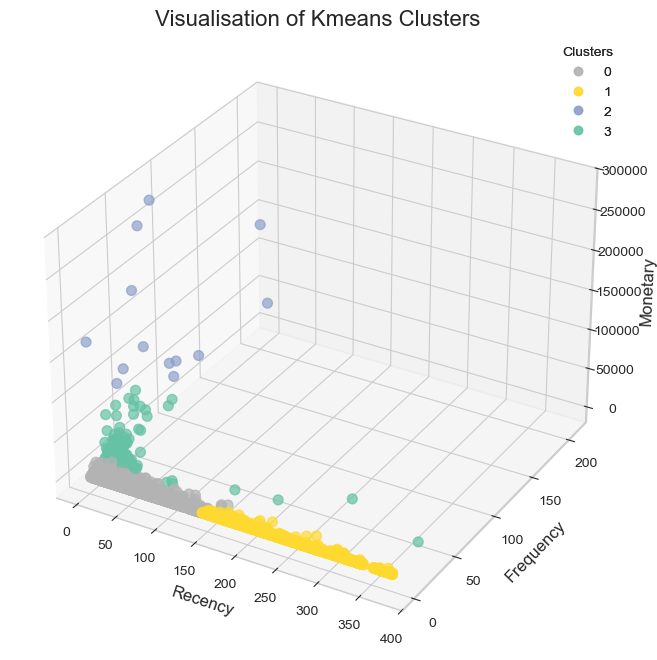

In [56]:
# plot the clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    rfm_data["Recency"],
    rfm_data["Frequency"],
    rfm_data["Monetary"],
    c=rfm_data["Cluster"],
    cmap="Set2_r",
    s=50,
    alpha=0.7,
)
ax.set_title("Visualisation of Kmeans Clusters", fontsize=16)
ax.set_xlabel("Recency", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_zlabel("Monetary", fontsize=12)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

**Findings from Q2:**

To gain the most comprehensive view of our customer base, we employed a dual-method approach for segmentation, moving from a standard business framework to a data-driven model.

1. Initial Tactical Segmentation (6 Segments via Manual RFM):
We first applied a standard RFM model to classify customers into six familiar, tactical segments (e.g., 'Loyal Customers', 'At Risk', 'Potential Loyalists'). This method is excellent for providing a detailed, granular view that marketing teams can use for specific, targeted campaigns.

2. Strategic Grouping (4 Segments via K-Means):
Next, to identify the most statistically significant, high-level groups, we used a K-Means clustering algorithm on the RFM data. This "bottom-up" approach listened to the natural patterns in the data and consolidated the customer base into four distinct, mathematically-optimized clusters.

**Reconciliation and Strategic Insight:**

The four K-Means clusters represent a strategic overview and should be seen as a consolidation of the six tactical segments. For instance, the K-Means algorithm found that from a purely behavioral standpoint, the purchasing patterns of our 'At Risk' and 'Lost' customers were similar enough to be grouped into a single large 'Inactive' cluster.

By using both models, we achieve a powerful, multi-layered view:

- **For high-level strategy:** We focus on the four core K-Means clusters (e.g., 'VIPs', 'Important Customers', 'Loyal Core', 'Dormant or Lost').

- **For tactical execution (Marketing view):** We can drill down into the six RFM segments to tailor specific messages and campaigns.

This dual approach ensures our strategy is based on robust, data-driven groups, while our execution remains agile and precise.

### Q3. Are there specific countries that contribute more to sales or have unique buying patterns?

Absolutely. We can analyze this by grouping sales data by `Country`. The vast majority of sales come from the UK, so I'll create one chart including the UK and another one excluding it to better visualize the contributions of other countries.

In [57]:
country_sales = (
    df_sales.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False)
)

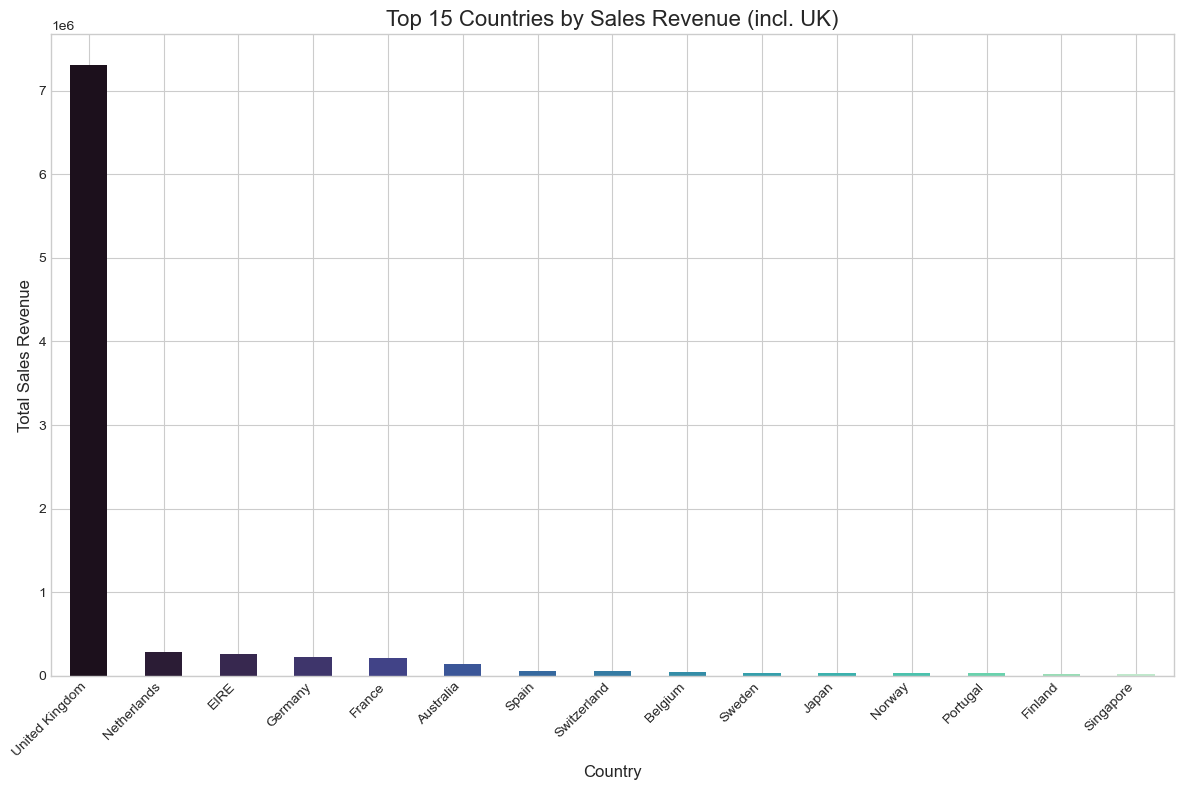

In [58]:
plt.figure(figsize=(12, 8))
country_sales.head(15).plot(kind="bar", color=sns.color_palette("mako", 15))
plt.title(
    "Top 15 Countries by Sales Revenue (incl. UK)", fontsize=16
)  # title: Top 15 countries by sales revenue (including UK)
plt.xlabel("Country", fontsize=12)  # xlabel: country
plt.ylabel("Total Sales Revenue", fontsize=12)  # ylabel: total sales revenue
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

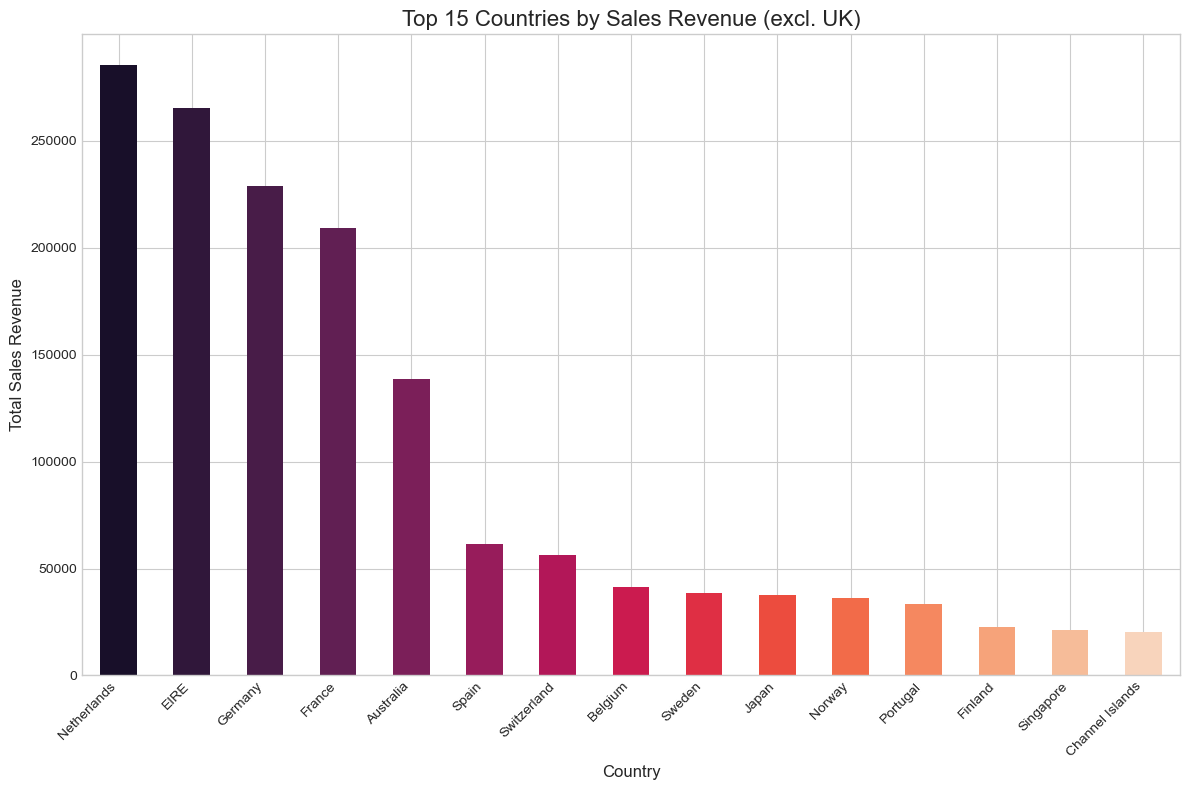

In [59]:
plt.figure(figsize=(12, 8))
country_sales.drop("United Kingdom").head(15).plot(
    kind="bar", color=sns.color_palette("rocket", 15)
)
plt.title(
    "Top 15 Countries by Sales Revenue (excl. UK)", fontsize=16
)  # title: Top 15 Countries by Sales Revenue (excl. UK)
plt.xlabel("Country", fontsize=12)  # xlabel: country
plt.ylabel("Total Sales Revenue", fontsize=12)  # ylabel: total sales revenue
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Findings from Q3:**

- Dominance of the UK: The first chart confirms that the business is heavily UK-centric, with domestic sales dwarfing international sales.

- Top International Markets: The second chart provides a clearer view of the international landscape. The Netherlands, EIRE (Ireland), Germany, and France are the next four largest markets, with significant sales contributions.

- Buying Patterns: While a deeper dive is needed for "unique patterns," the high sales value from these nearby European countries suggests a strong market presence and logistical efficiency in the region. There might be an opportunity to create targeted marketing campaigns (e.g., in local languages) for these countries to further boost sales. The presence of Australia as a top market is also interesting, indicating a potential for expansion into other non-European, English-speaking countries.

### Q4 (Bonus). How do cancellations impact overall sales trends?

To analyze cancellations, I'll go back to the cleaned data (before we removed negative quantities) and create a separate dataframe for cancelled orders. An invoice number starting with 'C' also indicates a cancellation.

I will then compare the monthly value of sales versus the monthly value of cancellations.


In [60]:
# Create a dataframe for cancellations.
df_cancellations = df[df["InvoiceNo"].str.startswith("C", na=False)].copy()
df_cancellations["TotalPrice"] = (
    df_cancellations["Quantity"] * df_cancellations["UnitPrice"]
)
df_cancellations["YearMonth"] = df_cancellations["InvoiceDate"].dt.to_period("M")

In [61]:
# Calculate monthly sales and cancellations.
monthly_sales_val = df_sales.groupby("YearMonth")["TotalPrice"].sum().reset_index()
monthly_sales_val.rename(columns={"TotalPrice": "SalesValue"}, inplace=True)
monthly_cancellations_val = (
    df_cancellations.groupby("YearMonth")["TotalPrice"].sum().abs().reset_index()
)
monthly_cancellations_val.rename(
    columns={"TotalPrice": "CancellationValue"}, inplace=True
)

In [62]:
# Merge the trends.
monthly_trends = pd.merge(
    monthly_sales_val, monthly_cancellations_val, on="YearMonth", how="left"
).fillna(0)
monthly_trends["YearMonth"] = monthly_trends["YearMonth"].astype(str)

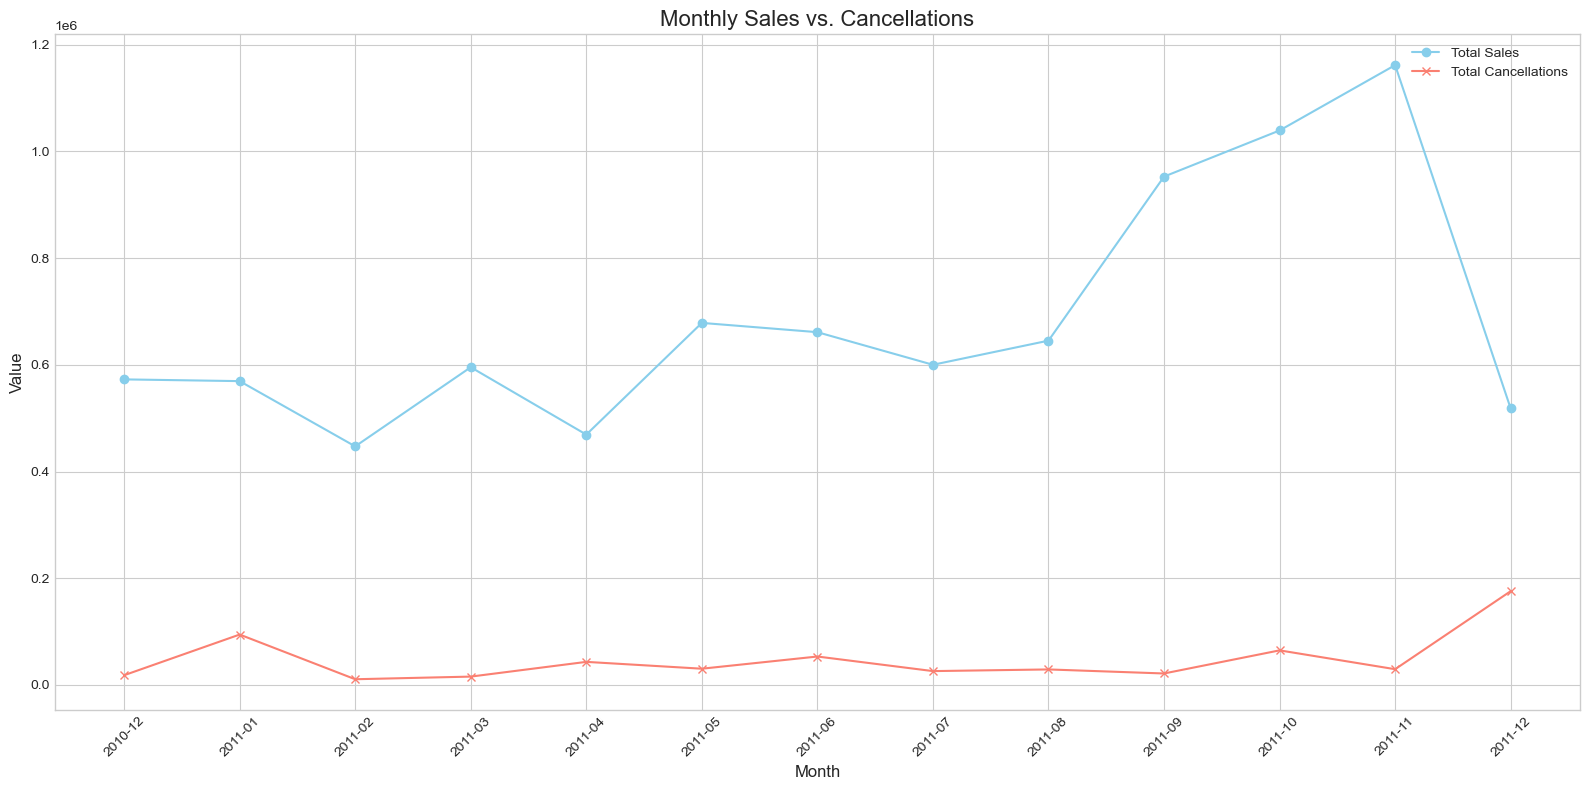

In [63]:
# Visualization for Q4.
plt.figure(figsize=(16, 8))
plt.plot(
    monthly_trends["YearMonth"],
    monthly_trends["SalesValue"],
    label="Total Sales",
    color="skyblue",
    marker="o",
)
plt.plot(
    monthly_trends["YearMonth"],
    monthly_trends["CancellationValue"],
    label="Total Cancellations",
    color="salmon",
    marker="x",
)
plt.title(
    "Monthly Sales vs. Cancellations", fontsize=16
)  # title: Monthly Sales vs. Cancellations
plt.xlabel("Month", fontsize=12)  # xlabel: month
plt.ylabel("Value", fontsize=12)  # ylabel: value
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
# Calculate and print the overall cancellation rate.
total_sales_value = monthly_trends["SalesValue"].sum()
total_cancellation_value = monthly_trends["CancellationValue"].sum()
cancellation_rate = (
    total_cancellation_value / (total_sales_value + total_cancellation_value)
) * 100

# Define the labels for printing
label1 = "Total Sales Value:"
label2 = "Total Cancellation Value:"
label3 = "Overall Cancellation Rate:"

# Determine the maximum length of the labels for alignment
# This ensures that the values following the labels will be vertically aligned.
max_label_length = max(len(label1), len(label2), len(label3))

print(f"{label1:<{max_label_length}} £{total_sales_value:,.2f}")
print(f"{label2:<{max_label_length}} £{total_cancellation_value:,.2f}")
print(f"{label3:<{max_label_length}} {cancellation_rate:.2f}%")

Total Sales Value:         £8,911,407.90
Total Cancellation Value:  £611,342.09
Overall Cancellation Rate: 6.42%


**Findings from Q4 (Bonus):**

- **Cancellation Trend:** The value of cancellations generally follows the trend of sales, peaking during the high-volume sales months at the end of the year. This is logical, as more orders naturally lead to more cancellations.

- **Financial Impact:** The total value of cancelled orders over the year is over £611k, which is significant. The overall cancellation rate is approximately 6.42% of the gross transaction value (Sales + Cancellations).

- **Actionable Insight:** While some level of cancellation is unavoidable, a rate of over 6% is worth investigating. The business could analyze the most frequently cancelled items or identify customers with high cancellation rates. This could point to issues with product descriptions, delivery problems, or even fraudulent behavior.

## Summary & Reflection

### Key Takeaways:

1. **Sales are Seasonal:** The business has a strong seasonal peak in Q4, driven by holiday shopping. This is a critical period for revenue, and marketing/inventory planning should be heavily focused here.

2. **Customer Value varies Greatly:** A core group of "Improtant" and "VIP" customers drives a significant portion of the business. Retention and engagement strategies for these segments are crucial. Conversely, "At Risk" customers present a key opportunity for re-engagement before they are lost.

3. **UK is the Core Market, Europe is the Opportunity:** While the UK is the primary market, nearby European countries like the Netherlands, Ireland, and Germany represent the biggest growth opportunities for international expansion.

4. **Cancellations are a Costly Issue:** Cancellations represent a tangible loss of revenue. A deeper dive into why orders are cancelled could lead to process improvements and cost savings.

### Further Discussion & Possibilities:

- **Market Basket Analysis:** We could analyze which products are frequently purchased together. This can inform cross-selling strategies, product bundling, and store layout optimization (e.g., "Customers who bought X also bought Y").

- **Time Series Forecasting:** With more historical data, we could build a forecasting model to predict future sales, helping with inventory management and financial planning.

- **External Factors:** The observed trends are likely influenced by external factors not in the dataset. For example, the 2011 economic climate in the UK and Europe could have affected consumer spending. Major marketing campaigns or competitor actions would also have a significant impact. Analyzing these alongside the sales data would provide a more complete picture.

This comprehensive analysis provides a solid foundation for strategic decision-making. The next logical step, as outlined in your assignment, would be to present these key findings in a clear and interactive Tableau dashboard for the CEO.